In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import constants
#sns.set_theme()
import re
import utils
from scipy import ndimage
from scipy.signal import lfilter

import cv2

# Read data

In [76]:
#Record_2022-09-27_14-14-14.bin
no_reflector = "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin"
best_restult = "felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin"
munkholm = "felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin"
try:
    #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
    #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
    with open(no_reflector, "rb") as f:

        data = f.read()
    
        
        
except IOError as e:
    print(e)

In [77]:
stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
    ls = re.search(stri.encode(), data_bytes).end()
    data_arr.append(data_bytes[:ls])
    data_bytes = data_bytes[ls+4:]
    print(len(data_bytes))
    if(len(data_bytes) == 0):
        done = True

1055904504
1054855668
1053806832
1052758020
1051709208
1050660384
1049611536
1048562724
1047513888
1046465028
1045416224
1044367376
1043318564
1042269728
1041220892
1040172056
1039123244
1038074468
1037025668
1035976832
1034928020
1033879232
1032830420
1031781620
1030732844
1029684032
1028635244
1027586444
1026537656
1025488844
1024440044
1023391244
1022342468
1021293644
1020244796
1019195948
1018147124
1017098288
1016049508
1015000692
1013951888
1012903072
1011854292
1010805560
1009756804
1008708048
1007659244
1006610488
1005561708
1004512928
1003464160
1002415368
1001366612
1000317856
999269124
998220356
997171576
996122796
995074028
994025284
992976516
991927736
990878932
989830164
988781384
987732616
986683860
985635116
984586360
983537572
982488760
981439960
980391172
979342384
978293584
977244748
976195960
975147148
974098312
973049488
972000652
970951864
969903040
968854276
967805488
966756688
965707888
964659088
963610276
962561464
961512616
960463792
959414956
958366132
957317

AttributeError: 'NoneType' object has no attribute 'end'

# Background update algorithem

In [4]:
def simple_exp_smooth(d,extra_periods=1,alpha=0.4):  
  #d = np.array(d)  # Transform the input into a numpy array  
  cols = len(d)  # Historical period length  
  #d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
  f = np.zeros_like(d)  # Forecast array  
  f[0] = d[0]  # initialization of first forecast  
 
  # Create all the t+1 forecasts until end of historical period  
  for t in range(1,cols):  
    f[t] = alpha*d[t]+(1-alpha)*f[t-1]
  #print(f)  
  f[cols+1:] = f[t]  # Forecast for all extra periods  
  #df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f})
  return f,d

In [5]:
c = constants.c
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
frame_rate =50*10**(-3) # frame rate
sample_per_frame = 260*257 # sample pr frame
c_t = (1/sample_bandwidth )*256 # sample period
#fs_new = 1/sample_period_new # sample frekuenzy 

In [44]:
def background_update(frames, alpha=1/128, nr_of_ma=1):
    fft_length = 256
    MRDM =np.zeros((len(frames),fft_length,fft_length),dtype=np.complex_)
    
    for i,frame in enumerate(frames):
        length = int.from_bytes(
                 frame[4:8], byteorder="little", signed=False)
        
        data_RADC = frame[8:8+length]
        data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
        data_RADC = data_RADC.reshape(3,256,512)
        data_RADC_I_raw = data_RADC[:,:,::2]
        data_RADC_Q_raw = data_RADC[:,:,1::2]
        data_RADC_I = detrend(data_RADC_I_raw, axis=2)
        data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)
        window = 1#signal.windows.hann(256)
        #data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
        #data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
        data_RADC_I_mean = data_RADC_I[0]
        data_RADC_Q_mean = data_RADC_Q[0]
        data_IF = window*data_RADC_I_mean[:,:] + window*1j*data_RADC_Q_mean[:,:]
       

        data_range_baseline =utils.fft_and_plot(data_IF, axis=1, fs=sample_frek,fft_size=fft_length,plot=False,shift =False)
       #data_range_baseline = utils.MIT_filter( data_range_baseline)
        for j in range(fft_length):
             data_range_baseline[:,j] = window*data_range_baseline[:,j]
        data_range_baseline = utils.MIT_filter( data_range_baseline)
        data_doppler_window_slow= utils.fft_and_plot(data_range_baseline, axis=0,fft_size=fft_length,shift =True)
     
        #MRDM[i]=cv2.GaussianBlur(np.abs(data_doppler_window_slow) ,(3, 3),sigmaX=1,sigmaY=1)
        MRDM[i] = data_doppler_window_slow

    #MIT
   
   
    data_diff = MRDM
    raw_frames = MRDM
    for i in range(nr_of_ma):
        MRDM,frames =simple_exp_smooth(data_diff,alpha =alpha)
        data_diff = np.abs(frames) -np.abs(MRDM)
        print("MA",i)
    #data_diff = np.abs(frames[-1]) -np.abs(MRDM[-2])
    utils.CFAR_2D(data_diff[-1].copy(),10, 15, 0.000001,plot=False, iso_axis=True)
    return MRDM,raw_frames,data_diff

In [82]:

idx = 301
data_ma,raw_t,data_diff = background_update(data_arr[1:-1],nr_of_ma=
3, alpha=1/256)



MA 0
MA 1
MA 2


In [ ]:
print(len(data_diff))

In [ ]:
%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})

plt.figure(figsize=(10,10))

rotated_img =ndimage.rotate(data_diff[450],90)
#rotated_img =20*np.log10(np.abs(test)) # We rotate the image so the x axis is the velocity
rotated_img =20*np.log10(np.abs(rotated_img)) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
#plt.imshow(rotated_img,cmap="plasma", vmin=-10,vmax=50)
plt.imshow(rotated_img,cmap="plasma")
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
#plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



#plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

In [72]:
no_ema =data_diff

78.33256851785147
92.88829800064293
117.74173153646328
118.60512007351964


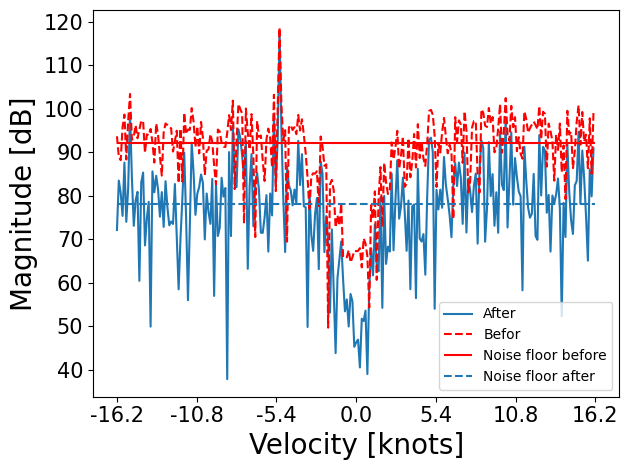

In [75]:
plt.figure()

rotated_diff = ndimage.rotate(data_diff[450], 90)
rotated_raw = ndimage.rotate(no_ema[450], 90)
print(np.mean(20*np.log10(np.abs(rotated_diff[137,:85]))))
print(np.mean(20*np.log10(np.abs(rotated_raw[137,:85]))))
print(np.max(20*np.log10(np.abs(rotated_diff[137,:]))))
print(np.max(20*np.log10(np.abs(rotated_raw[137,:]))))
plt.plot(20*np.log10(np.abs(rotated_diff[137,:])),label="After")
plt.plot(20*np.log10(np.abs(rotated_raw[137,:])),'--',label="Befor",color = "red")
plt.hlines(92,0,256,label="Noise floor before",colors=["red"])
plt.hlines(78,0,256,label="Noise floor after",linestyles=["--"])
plt.legend()
#plt.title("SNR befor and after EWMA",size=25)
plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("Velocity [knots]",size=20)
plt.ylabel("Magnitude [dB]",size=20)
plt.tight_layout()
#plt.savefig("plots/befor_and_after_EMA_new.svg",format="svg")
plt.show()


# Plot moving average

In [11]:
plot_min_range = 40
plot_max_range = 120
plot_min_doppler = 100
plot_max_doppler = 150
plot_min_3d = 80
plot_max_3d = 95

In [ ]:
%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(10,10))
rotated_img = ndimage.rotate(20*np.log10(np.abs(data_diff[450])),90) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
plt.imshow(rotated_img,cmap="plasma", vmin=plot_min_doppler,vmax=plot_max_doppler)
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
#plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)


#plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

# Plot Fitler frames

In [ ]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)

def animate(i):
    rotated_img = ndimage.rotate(data_diff[i],90)
    ax1.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000)
    ax1.set_title(f"Frame: {i}")
    ax1.set_xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
    ax1.set_yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    ax1.autoscale(enable=True, axis='both')

#ani = FuncAnimation(fig, animate,600 ,interval=100,cache_frame_data=False)
#plt.show()

# Calculate and plot CFAR

In [19]:
print(data_diff[100:500].shape)

(400, 256, 256)


In [83]:
cfar_array= []
SNR_array = []
SNR_D_array = []
length_data_diff = len(data_diff[500:])
for i,img in enumerate( data_diff[500:]):
    cfar ,y,SNR,d = utils.CFAR_2D(img,10, 15, 0.000001,plot=False, iso_axis=True)
    cfar_array.append(cfar)
    SNR_array.append(SNR)
    SNR_D_array.append(y)
    print(np.round(i/length_data_diff*100,1))

0.0
0.2
0.4
0.6
0.8
1.0
1.2
1.4
1.6
1.8
2.0
2.2
2.4
2.6
2.8
3.0
3.2
3.4
3.6
3.8
4.0
4.2
4.4
4.6
4.8
5.0
5.1
5.3
5.5
5.7
5.9
6.1
6.3
6.5
6.7
6.9
7.1
7.3
7.5
7.7
7.9
8.1
8.3
8.5
8.7
8.9
9.1
9.3
9.5
9.7
9.9
10.1
10.3
10.5
10.7
10.9
11.1
11.3
11.5
11.7
11.9
12.1
12.3
12.5
12.7
12.9
13.1
13.3
13.5
13.7
13.9
14.1
14.3
14.5
14.7
14.9
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.4
16.6
16.8
17.0
17.2
17.4
17.6
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.4
19.6
19.8
20.0
20.2
20.4
20.6
20.8
21.0
21.2
21.4
21.6
21.8
22.0
22.2
22.4
22.6
22.8
23.0
23.2
23.4
23.6
23.8
24.0
24.2
24.4
24.6
24.8
25.0
25.1
25.3
25.5
25.7
25.9
26.1
26.3
26.5
26.7
26.9
27.1
27.3
27.5
27.7
27.9
28.1
28.3
28.5
28.7
28.9
29.1
29.3
29.5
29.7
29.9
30.1
30.3
30.5
30.7
30.9
31.1
31.3
31.5
31.7
31.9
32.1
32.3
32.5
32.7
32.9
33.1
33.3
33.5
33.7
33.9
34.1
34.3
34.5
34.7
34.9
35.0
35.2
35.4
35.6
35.8
36.0
36.2
36.4
36.6
36.8
37.0
37.2
37.4
37.6
37.8
38.0
38.2
38.4
38.6
38.8
39.0
39.2
39.4
39.6
39.8
40.0
40.2
40.4
40.6
40.8
41.0
41.2
41.4
4

In [ ]:
cfar_EMA_3 = cfar_array

In [ ]:
cfar_EMA = cfar_array

(256, 256)


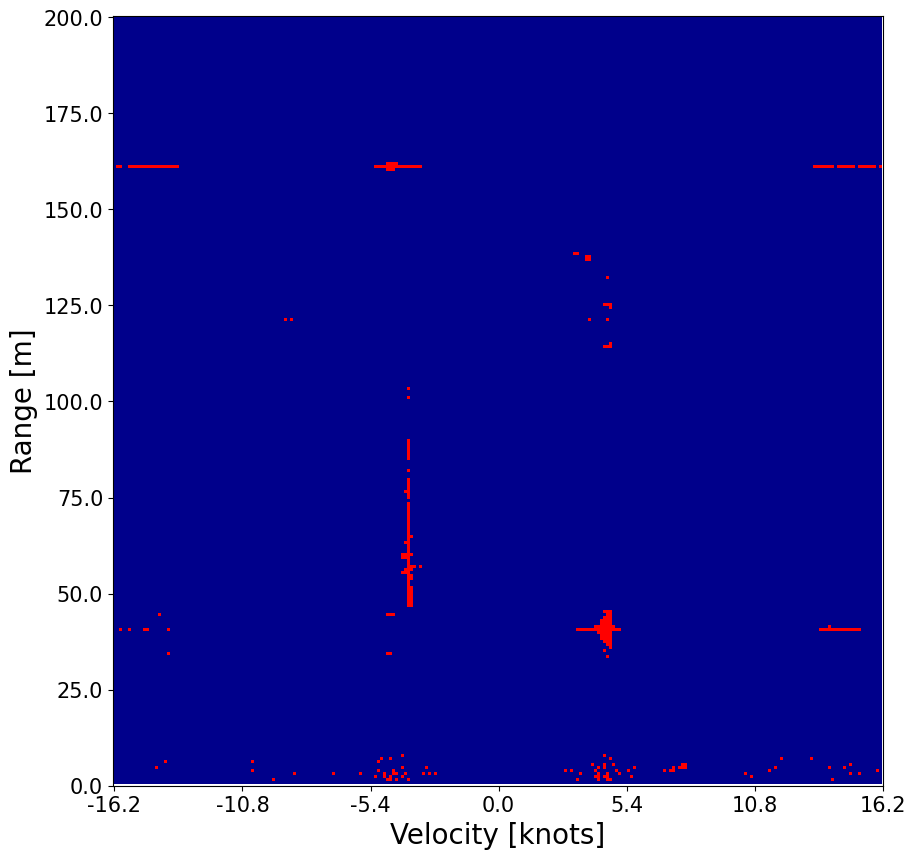

In [88]:
import matplotlib as mpl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
test = np.max(np.abs(SNR_D_array[:400]),axis=0)
test[test < 1.1] =0
test[test>1] =1
plt.figure(figsize=(10,10))
print(np.shape(test))
rotated_img =np.abs(test) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
cmap = mpl.colors.ListedColormap(['darkBlue','red'])
bounds=[-0,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(rotated_img,interpolation='nearest',cmap = cmap,norm=norm)
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)


plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
#cbar  = plt.colorbar()
#cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
#cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
#plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
#plt.savefig("cfar_io/no_reflector_result.svg",format="svg")
plt.show()

20.933458446931883
20.933458446931883


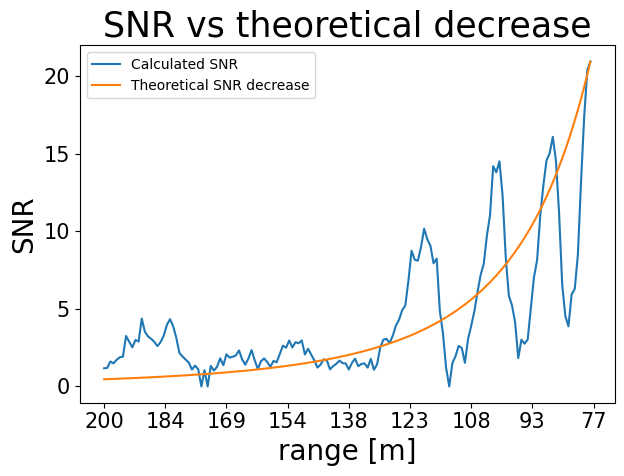

In [19]:
plt.figure()
start_bin =1
end_bin = 157

detections =np.max(np.abs(SNR_D_array[:400]),axis=0)
#detections  = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,86:88],axis=1))
#detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.plot(detection_line,label="Calculated SNR")

plt.plot(r_squared,label="Theoretical SNR decrease")

plt.legend()
plt.title("SNR vs theoretical decrease",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("SNR",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
#plt.savefig("plots/results/SNR_vs_falloff_best_results_with_window.png")
plt.show()

In [ ]:
cfar_IO= []
length_data_diff = len(data_diff[:-1])
for i,img in enumerate( data_diff[:-1]):
    cfar ,y,x = utils.CFAR_IO(img,10, 15, 0.000001,plot=False, iso_axis=True)
    cfar_IO.append(cfar)
    print(np.round(i/length_data_diff*100,1))

In [ ]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections IO"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
test = np.sum(np.abs(cfar_IO),axis=0)
test[test>0 ] =1
plt.figure(figsize=(10,10))
print(np.shape(test))

plt.imshow(test )
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)

plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
plt.savefig("plots/munkholm/cfar_IO_EMA_0_MTI_munkholm_with_window.svg",format="svg")

In [ ]:
plt.plot(rotated_img[100,:])

In [ ]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

fig_cfar=plt.figure()
ax1_cfar=fig_cfar.add_subplot(1,1,1)



def animate_cfar(i):
    rotated_img = ndimage.rotate(cfar_array[i],90)
    ax1_cfar.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000)
    ax1_cfar.set_title(f"Frame: {i}")
    ax1_cfar.set_xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
    ax1_cfar.set_yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    ax1_cfar.autoscale(enable=True, axis='both')

ani_cfar = FuncAnimation(fig_cfar, animate_cfar, interval=100)
plt.show()

In [ ]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(data_diff[-1], (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(20,15))
rotated_img = ndimage.rotate(data_diff[-1],90) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
plt.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000,)
rms = np.sqrt(np.mean(rotated_img[139,:])**2)
peak = rotated_img[137,87]
snr = 10*np.log10(peak/rms)
print("Peak:",peak)
print("RMS:",rms)
print("SNR:",snr)
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
#plt.xlim(60,100)
#plt.ylim(130,150)
plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

In [ ]:
plt.figure()
start_bin =1
end_bin = 157

detections =np.max(np.abs(SNR_D_array),axis=0)
#detections  = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,86:88],axis=1))
#detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.plot(detection_line,label="Calculated SNR")

plt.plot(r_squared,label="Theoretical SNR decrease")

plt.legend()
plt.title("SNR vs theoretical decrease",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("SNR",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
#plt.savefig("plots/SNR_vs_falloff_MRDM.png")
plt.show()

# Baseline, No MA

In [ ]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(20,15))
rotated_img = ndimage.rotate(np.abs(raw_t[-1]),90) # We rotate the image so the x axis is the velocity
plt.imshow(rotated_img,cmap="plasma",  vmin=50000,vmax=200000)
rms = np.sqrt(np.mean(rotated_img[139,:])**2)
peak = rotated_img[137,87]
snr = 10*np.log10(peak/rms)
print("Peak:",peak)
print("RMS:",rms)
print("SNR:",snr)
#plt.yticks(np.linspace(0,256,5),labels=np.round(np.linspace(255*0.785277,0,5)),size =15)


#plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2)
#plt.xlim(85,90)
#plt.ylim(135,140)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

In [ ]:
import numpy as np

def calc_2d_cfar(noise_levels, guard_cells, training_cells):
    # Calculate the number of training cells
    num_training_cells = (2 * training_cells + 1) * (2 * training_cells + 1) - (2 * guard_cells + 1) * (2 * guard_cells + 1)
    
    # Create a padding around the noise levels array to handle edge cases
    padded_noise_levels = np.pad(noise_levels, training_cells + guard_cells, mode="constant")
    
    # Create an empty array for the CFAR result
    cfar_result = np.zeros_like(noise_levels)
    
    # Iterate over the noise levels array and calculate the CFAR for each cell
    for i in range(noise_levels.shape[0]):
        for j in range(noise_levels.shape[1]):
            # Calculate the indices for the training cells
            i1 = i + training_cells
            i2 = i - training_cells
            j1 = j + training_cells
            j2 = j - training_cells
            
            # Calculate the indices for the guard cells
            i3 = i + guard_cells
            i4 = i - guard_cells
            j3 = j + guard_cells
            j4 = j - guard_cells
            
            # Calculate the average noise level for the training cells
            avg_noise_level = np.mean(padded_noise_levels[i1:i2+1, j1:j2+1])
            
            # Calculate the CFAR for the current cell
            cfar_result[i, j] = padded_noise_levels[i, j] / avg_noise_level
    
    return cfar_result
